## EMNIST Dataset

In [ ]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import numpy as np
import pandas as pd

mapping_path = 'emnist-letters-mapping.txt'

testing_data = pd.read_csv('emnist-letters-test.csv')
training_data = pd.read_csv('emnist-letters-train.csv')

X_train = np.array(training_data.iloc[:,1:].values)
y_train = np.array(training_data.iloc[:,0].values)

X_test = np.array(testing_data.iloc[:,1:].values)
y_test = np.array(testing_data.iloc[:,0].values)

X = np.concatenate((X_train, X_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)



In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

X_Normalized = X.astype('float32') / 255.0

X_reshape = X_Normalized.reshape(-1, 28, 28, 1)

X_resized = np.repeat(X_reshape, 3, axis=-1)

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(y.reshape(-1, 1))

y_encoded = encoder.transform(y.reshape(-1, 1))

X_train, X_val, y_train, y_val = train_test_split(
    X_resized, y_encoded, test_size=0.2, random_state=42, shuffle=True
)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(71115, 28, 28, 3)
(71115, 26)
(17779, 28, 28, 3)
(17779, 26)


In [58]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


datagen.fit(X_train)
datagen.fit(X_val)


def block(x, filters, stride=1, dropout_rate=0.3):
    identity = x

    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    if stride != 1 or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False)(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([identity, x])
    x = layers.ReLU()(x)

    return x

def resnet(input_tensor, num_classes=26, dropout_rate=0.3):
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=1, padding='same')(x)

    x = block(x, 64, stride=1, dropout_rate=dropout_rate)
    x = block(x, 128, stride=2, dropout_rate=dropout_rate)
    x = block(x, 256, stride=2, dropout_rate=dropout_rate)
    x = block(x, 512, stride=2, dropout_rate=dropout_rate)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    return x


input_tensor = tf.keras.Input(shape=(28, 28, 3))

model_output = resnet(input_tensor, num_classes=26, dropout_rate=0.3)

rn_model1 = models.Model(inputs=input_tensor, outputs=model_output)

In [59]:
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)

rn_model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rn_history1 = rn_model1.fit(X_train, y_train_int, batch_size=32, epochs=5, validation_data=(X_val, y_val_int))

rn_model1.save('rn_model1.keras')

Epoch 1/5
2223/2223 [==============================] - 169s 75ms/step - loss: 0.6187 - accuracy: 0.8157 - val_loss: 0.4728 - val_accuracy: 0.8461
Epoch 2/5
2223/2223 [==============================] - 177s 80ms/step - loss: 0.3102 - accuracy: 0.8987 - val_loss: 0.4617 - val_accuracy: 0.8522
Epoch 3/5
2223/2223 [==============================] - 165s 74ms/step - loss: 0.2620 - accuracy: 0.9128 - val_loss: 0.2492 - val_accuracy: 0.9198
Epoch 4/5
2223/2223 [==============================] - 165s 74ms/step - loss: 0.2319 - accuracy: 0.9217 - val_loss: 0.2473 - val_accuracy: 0.9219
Epoch 5/5
2223/2223 [==============================] - 167s 75ms/step - loss: 0.2080 - accuracy: 0.9285 - val_loss: 0.2303 - val_accuracy: 0.9243


556/556 [==============================] - 9s 16ms/step


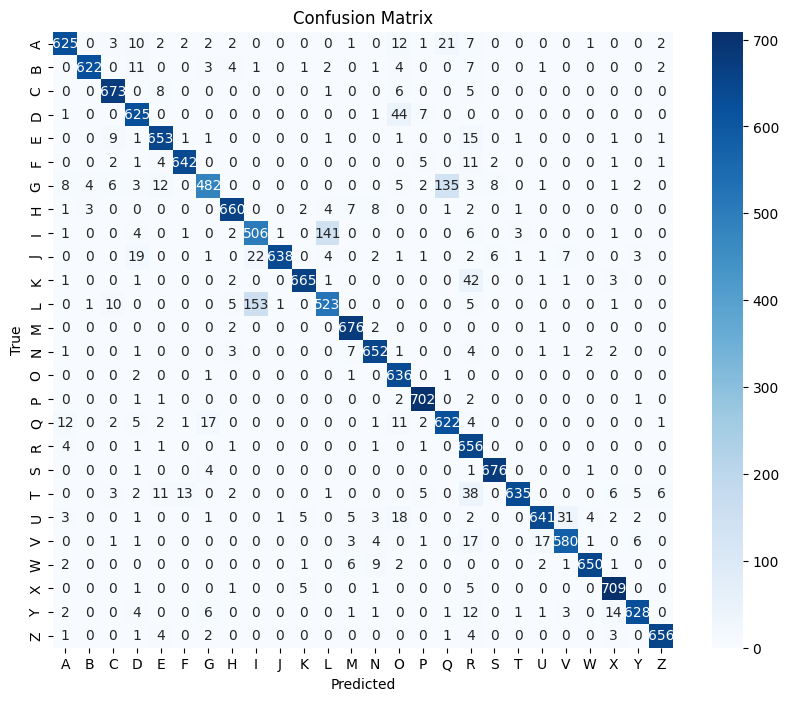

In [60]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = rn_model1.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)

y_test_labels = np.argmax(y_val, axis=1)

# Now, you can compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

labels = [chr(i) for i in range(65, 91)]  # ASCII values for A-Z

# Create the confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()